### [MAPLEAF.Motion](https://henrystoldt.github.io/MAPLEAF/Motion/index.html)
MAPLEAF's main purpose is to simulate the motion of a rocket as it flies up to space.
The rocket is treated as a rigid body.
The MAPLEAF.Motion module is responsible for performing these rigid body motion calculations and integrating the rocket's motion.

In each time step, the rest of MAPLEAF exists basically to estimate the forces and moments experienced by the rocket at any instant. These forces and moments are used to calculate the rocket's acceleration and angular acceleration using Newton's Second Law and [Euler's equations of rigid body motion](https://en.wikipedia.org/wiki/Euler%27s_equations_(rigid_body_dynamics)), which are then integrated to simulate the rocket's flight path.

In this notebook we're going to examine the data structures and classes in MAPLEAF.Motion that make this possible.

First, a several basic data types that are used throughout MAPLEAF are defined in MAPLEAF.Motion:
- Vector/AngularVelocity
- Quaternion
- Inertia
- ForceMomentSystem

**Vector** works as you would expect, and is used to represent things like positions and velocities

In [1]:
from MAPLEAF.Motion import Vector
a = Vector(1,2,3)

print(a)
print(a[0])
print(a+a)
print(a*2)
print(a*a) # Dot product
print(a.crossProduct(a))

(1.0 2.0 3.0)
1.0
(2.0 4.0 6.0)
(2.0 4.0 6.0)
14.0
(0.0 0.0 0.0)


**Quaternion**s are 4-component vectors used to represent the orientation of something relative to a reference orientation (Similarly to how a vector represents a position/velocity relative to a reference position/velocity).

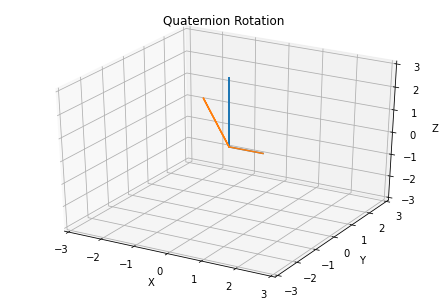

In [2]:
from MAPLEAF.Motion import Quaternion
import math
orientation = Quaternion(axisOfRotation=Vector(1,0,0), angle=math.radians(25))
orientation.plotRotation()

Orientations can be combined with *, or inverted with .conjugate()

**WARNING** Combining orientations is not commutative - order matters!

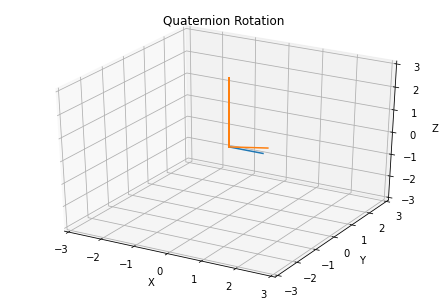

In [3]:
secondRotation = Quaternion(axisOfRotation=Vector(0,0,1), angle=math.radians(25))
secondRotation.plotRotation()

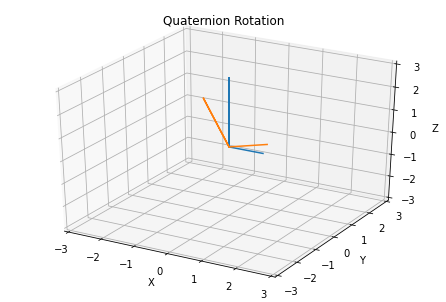

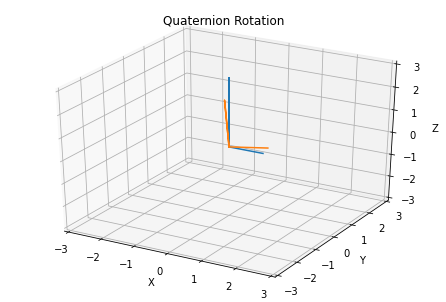

In [4]:
# 1st apply orientation, then second
a = orientation * secondRotation
a.plotRotation()

# Reverse order
b = secondRotation * orientation
b.plotRotation()

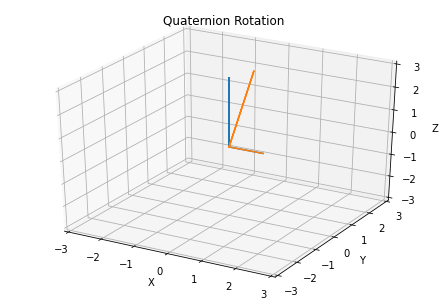

In [5]:
reverseRotation = orientation.conjugate()
reverseRotation.plotRotation()

**Inertia**s are summable objects that represent the combination of an object's mass, CG location, and moments of inertia (about the CG). At each force evaluation, the rocket calculates its mass by summing the masses of all its components.

In [6]:
from MAPLEAF.Motion import Inertia
noseConeInertia = Inertia(MOI=Vector(10, 10, 0.05), CG=Vector(0,0, -1), mass=10)
bodyTubeInertia = Inertia(MOI=Vector(20, 20, 0.1), CG=Vector(0,0, -2), mass=20)

totalInertia = noseConeInertia + bodyTubeInertia
print(totalInertia)

MOI=(36.666666666666664 36.666666666666664 0.15000000000000002) calculated about CG=(0.0 0.0 -1.6666666666666667); Mass=30 


**ForceMomentSystem**s are summable objects that represent a repositionable force-moment system. At each force evaluation, the total force applied is calculated by summing the force-moment systems applied by each rocket sub component.

In [7]:
from MAPLEAF.Motion import ForceMomentSystem
finForces = ForceMomentSystem(Vector(1,0,0), location=Vector(0,0,-4), moment=Vector(0,0,0.2)) # Force and Moment
bodyTubeForce = ForceMomentSystem(Vector(0.2,0,0), location=Vector(0,0,-2))

totalForce = finForces + bodyTubeForce
print(totalForce)

forceAtCenterOfBodyTube = totalForce.getAt(Vector(0,0,-2))
print(forceAtCenterOfBodyTube)

Force=(1.2 0.0 0.0) At=(0.0 0.0 -4.0) + Moment=(0.0 0.4 0.2)
Force=(1.2 0.0 0.0) At=(0.0 0.0 -2.0) + Moment=(0.0 -2.0 0.2)


**RigidBodyState**s combine 3 Vectors and one Quaternion to represent the state (position, velocity, orientation, angular velocity) of a rigid body at an instant in time:

In [8]:
from MAPLEAF.Motion import RigidBodyState, AngularVelocity
initState = RigidBodyState(position=Vector(0,0,0), velocity=Vector(1,0,0), orientation=Quaternion(1,0,0,0), angularVelocity=AngularVelocity(0,0,0))

print(initState.velocity)

(1.0 0.0 0.0)


**RigidBodyStateDerivative**s represent the time-derivative of a rigid body state, and are made up of four vectors (velocity, acceleration, angular velocity, angular acceleration):

In [9]:
from MAPLEAF.Motion import RigidBodyStateDerivative
stateDerivative = RigidBodyStateDerivative(velocity=Vector(1,0,0), acceleration=Vector(0,0,-9.8), angularVelocity=AngularVelocity(0,0,0), angularAccel=AngularVelocity(0,0,0))

To integrate motion using Euler's method, we do $y(t+dt) = y(t) + \frac{dy}{dt}*dt$. This works with MAPLEAF's rigid body states:

In [10]:
# dt = 0.1
stateTwo = initState + (stateDerivative*0.1)

print(stateTwo.position)
print(stateTwo.velocity)

(0.1 0.0 0.0)
(1.0 0.0 -0.9800000000000001)


While Euler integration is trivial to do manually, higher order and adaptive integration schemes are much more work to implement. Higher order and adaptive Runge-Kutta integration methods are defined in **MAPLEAF.Motion.Integration**.

This module is structured similarly to several others in MAPLEAF, with a 'factory' function that handles reading data from the SimDefinition, and then initializes and returns one of several actual classes.

In [11]:
from MAPLEAF.Motion import integratorFactory

# Create RK4 method (Sim Definition only required to create adaptive methods)
rk4 = integratorFactory(integrationMethod="RK4")

Because the rigidBodyStates are integrated exactly the same way as scalars (y + yprime*dt), the integration methods are general, and can integrate a scalar function just as well as 6-DOF motion:

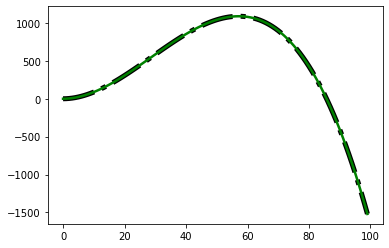

In [12]:
# Scalar integration demo
# Integrate with dx = 1.0 from 0-100

##### NUMERICAL INTEGRATION #####
def velocity(t, y):
    return 2*t - 0.035*t**2 # Derivative of Position = x^2 - 0.011666667*x^3

integratedPositions = []
t, pos = 0, 0

for i in range(100):
    integratedPositions.append(pos)
    pos = rk4(pos, t, velocity, 1.0)[0] # The integrator objects are directly callable 
    t += 1.0                              # (Acts like a function)
    
    
##### ANALYTICAL #####
def position(x):
    return x*x - 0.011666667*x**3

times = list(range(100))
analyticalPositions = [ position(x) for x in times ]


##### Show result #####
import matplotlib.pyplot as plt
plt.plot(times, analyticalPositions, '-.k', linewidth=5)
plt.plot(times, integratedPositions, 'g', linewidth=2.5)


In a rocket simulation, initializing an integrator, calculating rigid body state derivatives, and taking simulation time steps is controlled by the Rigid Body class.

A rigid body requires three things to be created: 
- Initial RigidBodyState, 
- Function to compute applied ForceMomentSystem applied to the body, as a function of rigidBodyState and time, and
- Similar function to compute the Inertia of the body

As mentioned earlier, most of the rest of MAPLEAF exists to provide those Force/Inertia estimation functions to the rigid body motion integration.

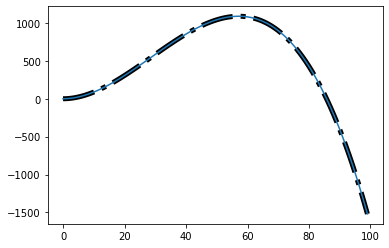

In [13]:
from MAPLEAF.Motion import RigidBody

#### Do Same Integration with RigidBody ####
inertia = Inertia(MOI=Vector(1,1,1), CG=Vector(0,0,0), mass=1)
def constantInertia(time, state):
    return inertia

def force(time, state):
    xForce = 2 - 0.07*time # B/c mass=1, this ends up being the same as the body's acceleration
    return ForceMomentSystem(Vector(xForce, 0, 0)) # Default moment/position is 0

initState = RigidBodyState() # Default is all zero state
testBody = RigidBody(initState, force, constantInertia, integrationMethod="RK4")

times, xPositions = [], []
for i in range(100):
    times.append(testBody.time)
    xPositions.append(testBody.state.position.X)
    testBody.timeStep(deltaT=1.0)

#### Show result vs analytical ####
plt.plot(times, analyticalPositions, '-.k', linewidth=5)
plt.plot(times, xPositions)

MAPLEAF's rocket class uses a RigidBody just like that to integrate its motion.
The MAPLEAF.Rocket, MAPLEAF.ENV, and MAPLEAF.GNC work together to model the rocket's inertia and applied forces during a flight.  
Timesteps are requested by the classes in MAPLEAF.SimulationRunners.